In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.linear_model import *
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

from lineartree import LinearTreeRegressor

In [2]:
### READ DATA ###

df = pd.read_csv("train.csv.zip", low_memory=False)
df = df[df['Open'] > 0]
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(['Store','Date'], inplace=True)
df.reset_index(inplace=True, drop=True)

print(df.shape)
df.head()

(844392, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,3,2013-01-02,5530,668,1,0,0,1
1,1,4,2013-01-03,4327,578,1,0,0,1
2,1,5,2013-01-04,4486,619,1,0,0,1
3,1,6,2013-01-05,4997,635,1,0,0,1
4,1,1,2013-01-07,7176,785,1,1,0,1


In [3]:
### READ STORE DATA ###

store = pd.read_csv("store.csv", low_memory=False)
n_stores = store.shape[0]

print(store.shape)
store.head()

(1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
### UTILITY FUNCTION FOR FEATURE GENERATION ###

def create_features(data):
    
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    data['CompetitionOpenMonths'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
                                    (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpenMonths'] = 12 * (data.Year - data.Promo2SinceYear) + \
                                (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpenMonths'] = data.CompetitionOpenMonths.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpenMonths'] = data.PromoOpenMonths.apply(lambda x: x if x > 0 else 0)
  
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data['PromoInterval'] = data['PromoInterval'].fillna('')
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [5]:
### MERGE SALES AND STORE DATA ###

df = pd.merge(df, store, on='Store')

del store
print(df.shape)
df.head()

(844392, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3,2013-01-02,5530,668,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2013-01-03,4327,578,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,5,2013-01-04,4486,619,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,6,2013-01-05,4997,635,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2013-01-07,7176,785,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [6]:
### CREATE FEATURES ###

df = create_features(df)
df.drop(['Customers', 'Open', 'PromoInterval', 'monthStr', 'Year'], axis=1, inplace=True)
df.set_index(['Date'], inplace=True)
df.fillna(-1, inplace=True)

print(df.shape)
df.head()

(844392, 19)


,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Month,WeekOfYear,CompetitionOpenMonths,PromoOpenMonths,IsPromoMonth
Date,,,,,,,,,,,,,,,,,,,
2013-01-02,1,3,5530,0,0,1,3,1,1270.0,9.0,2008.0,0,-1.0,-1.0,1,1,52.0,0.0,0
2013-01-03,1,4,4327,0,0,1,3,1,1270.0,9.0,2008.0,0,-1.0,-1.0,1,1,52.0,0.0,0
2013-01-04,1,5,4486,0,0,1,3,1,1270.0,9.0,2008.0,0,-1.0,-1.0,1,1,52.0,0.0,0
2013-01-05,1,6,4997,0,0,1,3,1,1270.0,9.0,2008.0,0,-1.0,-1.0,1,1,52.0,0.0,0
2013-01-07,1,1,7176,1,0,1,3,1,1270.0,9.0,2008.0,0,-1.0,-1.0,1,2,52.0,0.0,0


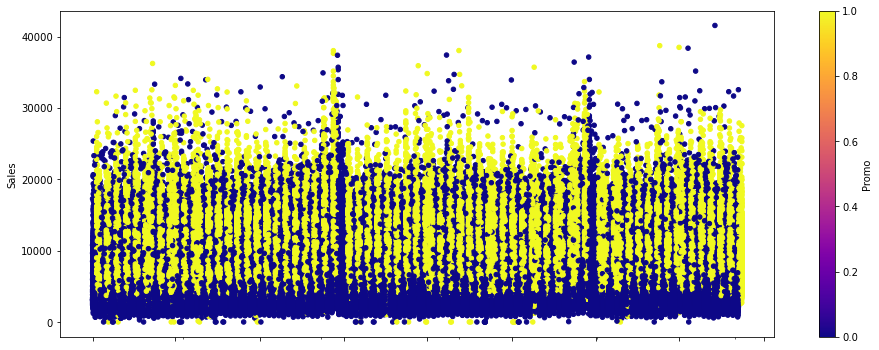

In [7]:
### SALES ON ALL STORES WITH PROMO ###

df[['Sales','Promo']].reset_index().plot.scatter('Date', 'Sales', figsize=(16,6), c='Promo', cmap='plasma')
plt.show()

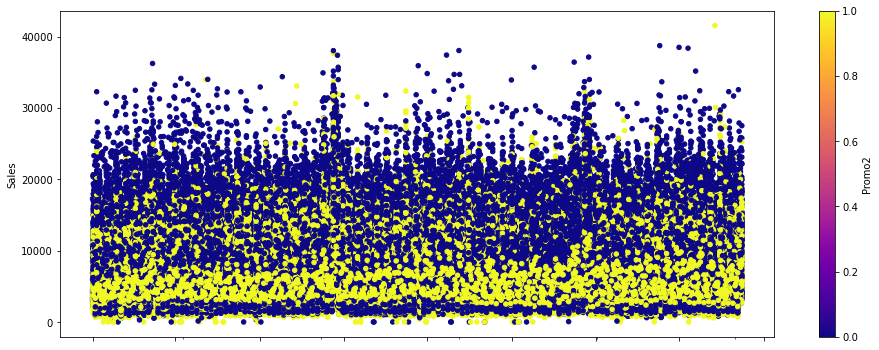

In [8]:
### SALES ON ALL STORES WITH PROMO2 ###

df[['Sales','Promo2']].reset_index().plot.scatter('Date', 'Sales', figsize=(16,6), c='Promo2', cmap='plasma')
plt.show()

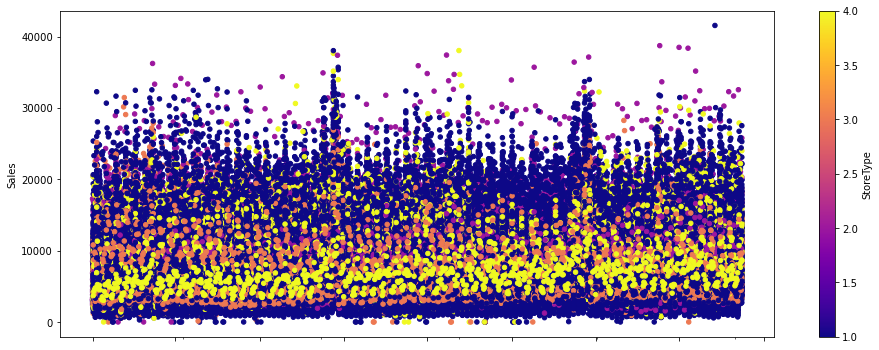

In [9]:
### SALES ON ALL STORES WITH STORETYPE ###

df[['Sales','StoreType']].reset_index().plot.scatter('Date', 'Sales', figsize=(16,6), c='StoreType', cmap='plasma')
plt.show()

In [10]:
### GET DATA FOR SINGLE STORE ###

id_shop = 111

X_train, X_test, y_train, y_test = train_test_split(
    df[df['Store'] == id_shop].drop('Sales', axis=1), 
    df[df['Store'] == id_shop]['Sales'], 
    test_size=0.3, shuffle=False)

X_train.shape, X_test.shape

((546, 18), (235, 18))

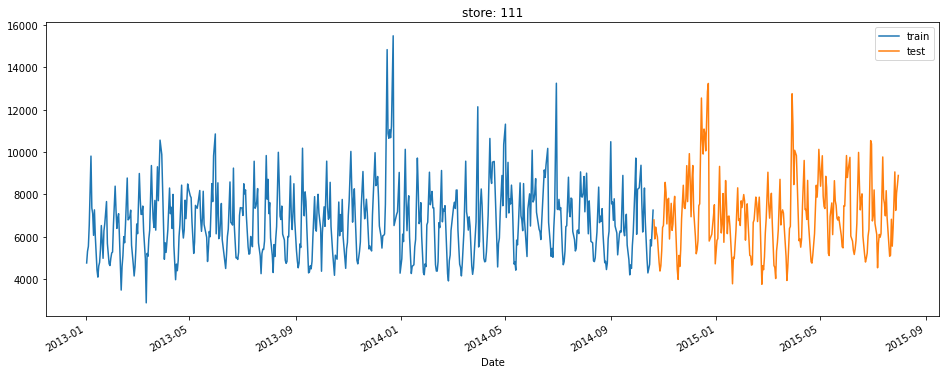

In [11]:
### PLOT STORE DATA ###

y_train.plot(label='train', figsize=(16,6))
y_test.plot(label='test')
plt.title("store: {}".format(id_shop)); plt.legend()

In [12]:
### TUNING LINEAR TREE FOR SINGLE STORE ###

model = GridSearchCV(estimator=LinearTreeRegressor(Ridge(), criterion='rmse', max_bins=10),
                     param_grid={'max_depth': [1, 2, 3], 'min_samples_split': [0.4, 0.3, 0.2]}, 
                     n_jobs=-1, cv=2, scoring='neg_mean_squared_error', refit=True)
model.fit(X_train, y_train)

model.best_params_

{'max_depth': 2, 'min_samples_split': 0.4}

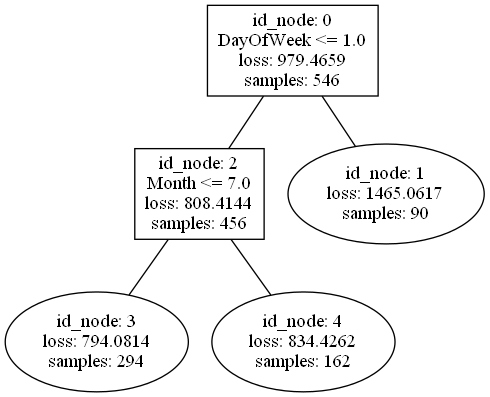

In [13]:
### PLOT MODEL DECISION PATH ###

model.best_estimator_.plot_model(feature_names=X_train.columns)

In [14]:
### COMPUTE TEST ERROR FOR LINEAR TREE ###

pred_lt = pd.Series(model.predict(X_test), index = y_test.index)
mean_squared_error(y_test, pred_lt, squared=False)

1163.7953687141164

In [15]:
### TUNING LINEAR REGRESSION FOR SINGLE STORE ###

model = GridSearchCV(estimator=Ridge(), param_grid={'alpha': [1, 3, 5, 10, 20]}, 
                     scoring='neg_mean_squared_error', cv=2, refit=True)
model.fit(X_train, y_train)

model.best_params_

{'alpha': 20}

In [16]:
### COMPUTE TEST ERROR FOR LINEAR REGRESSION ###

pred_lr = pd.Series(model.predict(X_test), index = y_test.index)
mean_squared_error(y_test, pred_lr, squared=False)

1341.0152852057852

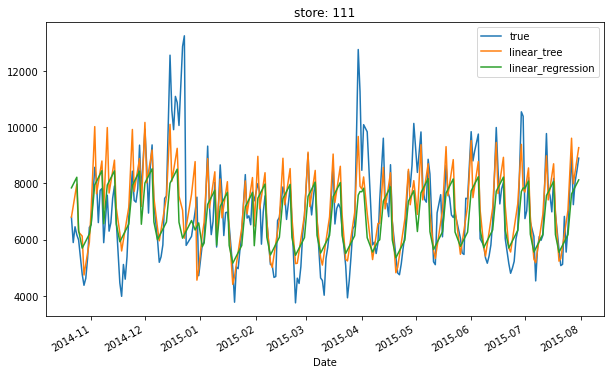

In [17]:
### PLOT AND COMPARE PREDICTIONS ON TEST SET ###

y_test.plot(label='true', figsize=(10,6))
pred_lt.plot(label='linear_tree')
pred_lr.plot(label='linear_regression')
plt.title("store: {}".format(id_shop)); plt.legend()

In [18]:
### FIT LINEAR TREE AND LINEAR REGRESSION FOR ALL THE STORE SEPARATELY ###

scores_lr = {}
scores_lt = {}
                 
for _,g_df in tqdm(df.groupby(['Store']), total=n_stores):

    _X_train, _X_test, _y_train, _y_test = train_test_split(
        g_df.drop('Sales', axis=1), g_df['Sales'], test_size=0.3, shuffle=False)
    
    model = GridSearchCV(estimator=Ridge(), param_grid={'alpha': [1, 3, 5]}, 
                     scoring='neg_mean_squared_error', cv=2, refit=True)
    model.fit(_X_train, _y_train)
    
    _pred = pd.Series(model.predict(_X_test), index = _y_test.index)
    scores_lr[_] = mean_squared_error(_y_test, _pred, squared=False)    

    model = GridSearchCV(estimator=LinearTreeRegressor(Ridge(), criterion='rmse', max_bins=10),
                         param_grid={'max_depth': [1, 2, 3], 'min_samples_split': [0.4, 0.3, 0.2]}, 
                         n_jobs=-1, cv=2, scoring='neg_mean_squared_error', refit=True)
    model.fit(_X_train, _y_train)
    
    _pred = pd.Series(model.predict(_X_test), index = _y_test.index)
    scores_lt[_] = mean_squared_error(_y_test, _pred, squared=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1115/1115 [11:32<00:00,  1.61it/s]


In [19]:
### COMPARE ERRORS OF ALL THE STORES ###

compare = {}

for (store,score_lr),(store,score_lt) in zip(scores_lr.items(), scores_lt.items()):
    
    if score_lr > score_lt:
        compare[store] = 'linear tree'
    elif score_lr < score_lt:
        compare[store] = 'linear regression'
    else:
        compare[store] = 'equal'

In [20]:
### GET COMPARISON RATIO ###

pd.Series(compare).value_counts() / len(compare)

linear tree          0.866368
linear regression    0.133632
dtype: float64

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

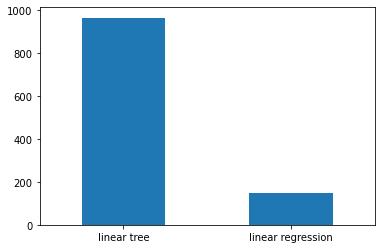

In [21]:
### PLOT PERFORMANCE ###

pd.Series(compare).value_counts().plot.bar()
plt.xticks(rotation=0)